# What Madness can I do with Computational Social Science?
(You are not expected to understand this)

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import networkx as nx
import spacy
import os

In [2]:
sns.set_style('white')
matplotlib.style.use('seaborn-poster') #sets the size of the charts
sns.set_palette(sns.color_palette('Set1'))

###### Loading for Later

In [3]:
nlp = spacy.load('en_core_web_md')
news = pd.read_pickle('news_data.pkl')
%time news['text_spacy'] = list(nlp.pipe(news['text'],n_process=-1))

CPU times: user 28.9 s, sys: 1.41 s, total: 30.3 s
Wall time: 2min 43s


# Loading the Data

In [5]:
tweets = pd.read_pickle('large_brexit_tweets.pkl')

In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104941 entries, 0 to 176764
Data columns (total 11 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   created_at                         104941 non-null  object 
 1   id                                 104941 non-null  int64  
 2   full_text                          104941 non-null  object 
 3   user.screen_name                   104941 non-null  object 
 4   user.id                            104941 non-null  int64  
 5   user.statuses_count                104941 non-null  int64  
 6   user.followers_count               104941 non-null  int64  
 7   retweeted_status.user.screen_name  76765 non-null   object 
 8   retweeted_status.user.id           76765 non-null   float64
 9   entities.user_mentions             104941 non-null  object 
 10  entities.hashtags                  104941 non-null  object 
dtypes: float64(1), int64(4), object(6)
memo

In [7]:
tweets.head()

,created_at,id,full_text,user.screen_name,user.id,user.statuses_count,user.followers_count,retweeted_status.user.screen_name,retweeted_status.user.id,entities.user_mentions,entities.hashtags
0,Tue Oct 29 11:37:47 +0000 2019,1189144295418290178,RT @BrexitPartyGB: Are you #Leave or #Remain?\...,dazthesnapper,175003031,2203,112,BrexitPartyGB,1.117561e+18,"[{'screen_name': 'BrexitPartyGB', 'name': 'The...","[{'text': 'Leave', 'indices': [27, 33]}, {'tex..."
1,Mon Oct 28 18:18:33 +0000 2019,1188882764109664257,Are you #Leave or #Remain?\nIf there was a sec...,BrexitPartyGB,1117561379358236673,1451,1545,NaN,NaN,[],"[{'text': 'Leave', 'indices': [8, 14]}, {'text..."
2,Tue Oct 29 11:37:47 +0000 2019,1189144295351209986,"RT @Townbat: It just sickens me everytime, the...",mark_gently,726336579770433536,14317,1981,Townbat,1.084424e+18,"[{'screen_name': 'Townbat', 'name': 'Tames Jow...",[]
3,Mon Oct 28 17:21:56 +0000 2019,1188868515530452994,"It just sickens me everytime, these people on ...",Townbat,1084424021310099456,4891,243,NaN,NaN,[],"[{'text': 'DitchBrexit', 'indices': [200, 212]..."
4,Tue Oct 29 11:37:47 +0000 2019,1189144294764011525,@CivilityW @jennysart1962 Tories are establish...,Dreamer10384678,1128995563532431361,3249,530,NaN,NaN,"[{'screen_name': 'CivilityW', 'name': 'Civilit...",[]


# When were these Tweets Posted?

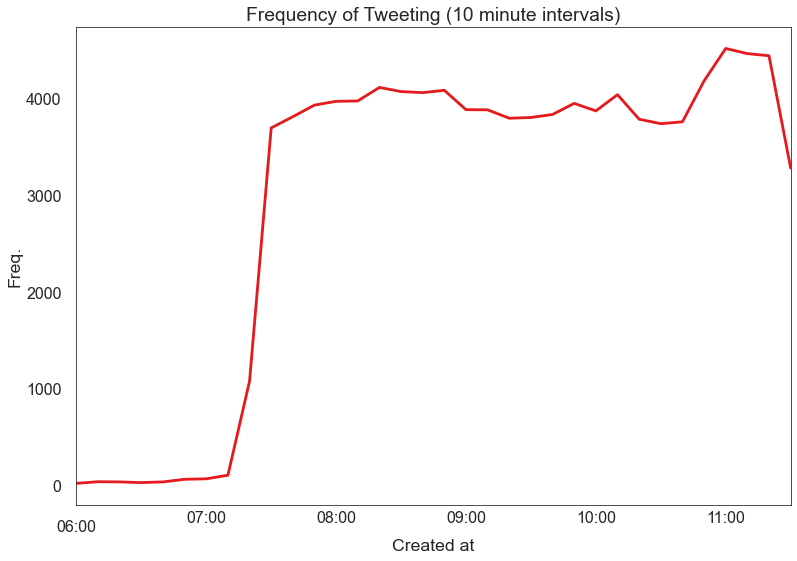

In [8]:
tweets['created_at'] = pd.to_datetime(tweets['created_at']) #easy!
time_grouper = pd.Grouper(key='created_at', freq='10min')
majority_filter = tweets['created_at'] > '29 October 2019 06:00'
majority = tweets[majority_filter]
majority.groupby(time_grouper).count()['id'].plot()
plt.xlabel('Created at')
plt.ylabel('Freq.')
plt.title('Frequency of Tweeting (10 minute intervals)')
plt.show()

# Top Hashtags

<AxesSubplot:>

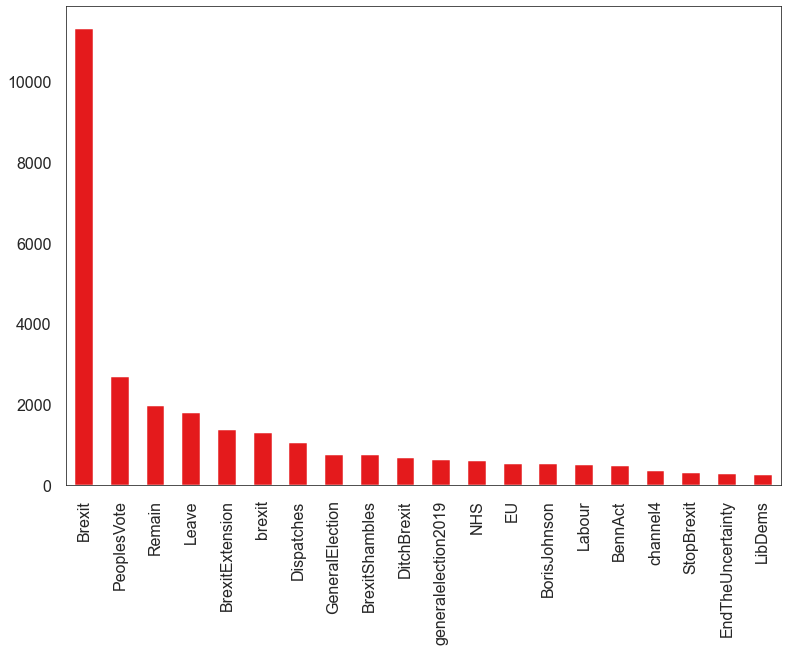

In [9]:
tweets['entities.hashtags'].apply(lambda x: [r['text'] for r in x]).explode().value_counts().head(20).plot(kind='bar')

# Binning Users by Number of Followers (Lower, Medium, Higher)

In [10]:
followers_counts = tweets.drop_duplicates('user.id')[['user.id','user.followers_count']].copy()
bin_labels = ['lower','medium','higher']
followers_counts['bin'] = pd.qcut(followers_counts['user.followers_count'], q=3, labels=bin_labels)
tweets = tweets.merge(followers_counts[['user.id','bin']], left_on='user.id', right_on='user.id')

# Top Hashtags Grouped by User Category

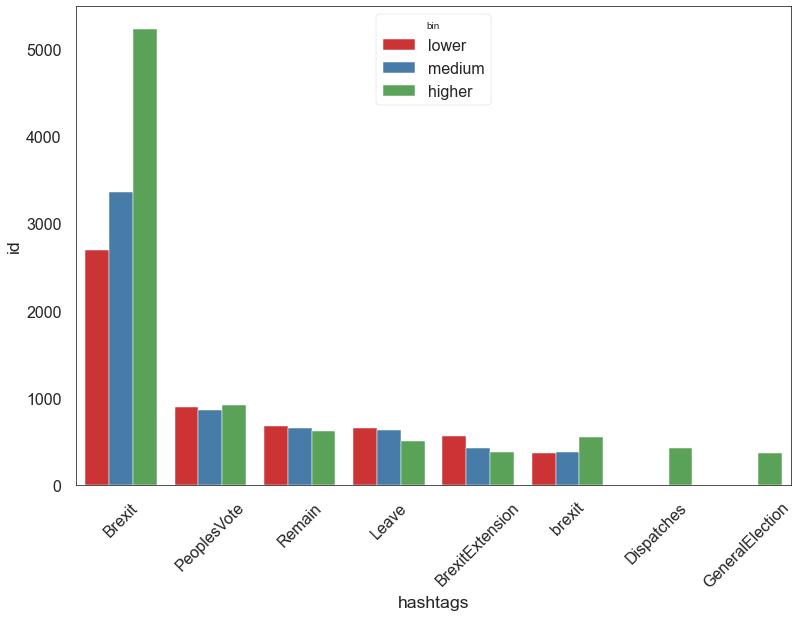

In [11]:
tweets['hashtags'] = tweets['entities.hashtags'].apply(lambda x: [r['text'] for r in x])
hashtag_data = tweets.explode('hashtags')[['hashtags','id','user.id','bin','user.followers_count']]
agg = hashtag_data.groupby(['hashtags','bin']).count().sort_values(by='id',ascending=False).head(20)['id'].reset_index()
chart = sns.barplot(data=agg, x='hashtags',y='id',hue='bin')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

# Follower Counts of Leavers vs Remainers
###### (Approximately)

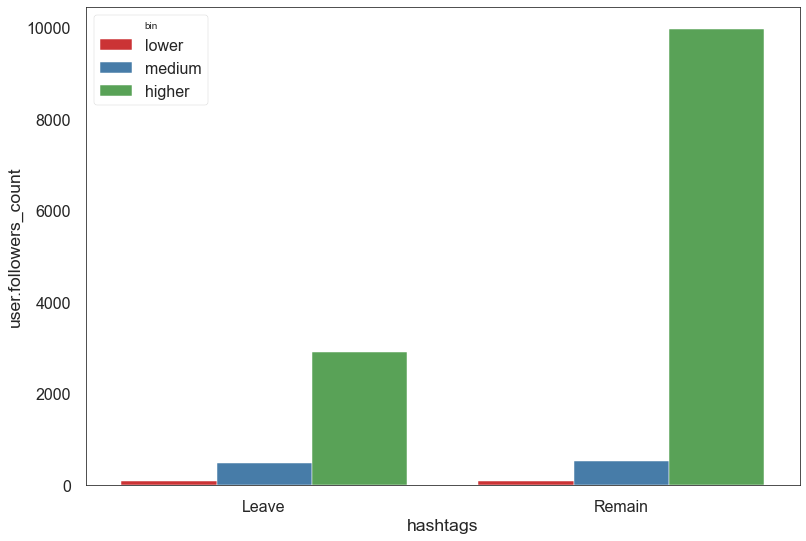

In [12]:
leaver_remainer = hashtag_data[ (hashtag_data['hashtags'] == 'Leave') | (hashtag_data['hashtags'] == 'Remain') ]
agg = leaver_remainer.drop_duplicates('user.id')
chart = sns.barplot(data=agg, x='hashtags',y='user.followers_count',hue='bin',ci=None)
plt.show()

# Converting to a Network of Hashtag Co-Occurence
How often are different hashtags used together? Let's look at the 100 most common co-occurences.

In [13]:
edges = hashtag_data.dropna(subset=['hashtags'])[['hashtags','id']]
G = nx.from_pandas_edgelist(edges, source='hashtags',target='id',create_using=nx.Graph)
projection = nx.algorithms.bipartite.weighted_projected_graph(G, edges['hashtags'].unique().tolist())
nx.set_node_attributes(projection,nx.degree_centrality(projection),'degree')
top_edges = [(edge[0],edge[1]) for edge in sorted(projection.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:100]]
top = projection.edge_subgraph(top_edges)

In [14]:
top.number_of_nodes()

53

In [15]:
top.number_of_edges()

100

# Visualise our Co-Occurence Network

In [16]:
# %%bash
# pip install ForceAtlas2

In [17]:
from forceatlas2 import forceatlas2_networkx_layout

No cython detected.  Install cython and compile the fa2util module for a 10-100x speed boost.


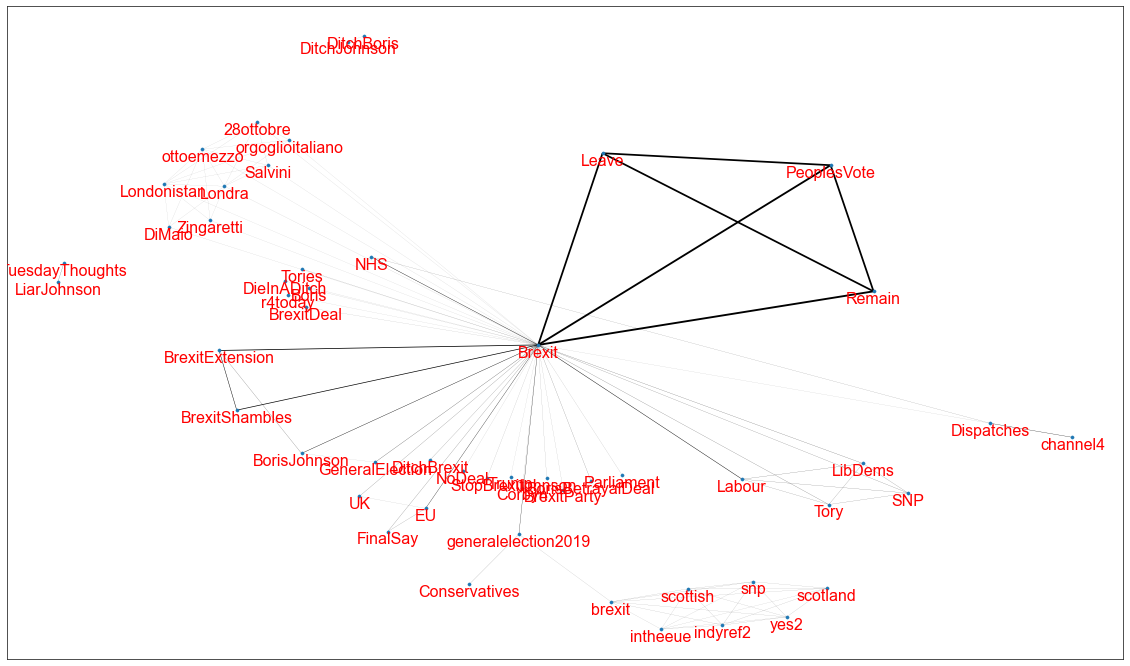

In [18]:
pos = forceatlas2_networkx_layout(top, strongGravityMode=True,edgeWeightInfluence=1)
weights = [top[u][v]['weight']/1000 for u,v in top.edges]
plt.figure(figsize=(20,12)) 
nx.draw_networkx(top, pos, width=weights, node_size=10,with_labels=False)
nx.draw_networkx_labels(top,pos=pos,font_color='red',font_size=16,horizontalalignment='center',verticalalignment='top')
plt.show()

# Who gets mentioned in the news?

In [19]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               972 non-null    object
 1   query              972 non-null    object
 2   thread.title_full  972 non-null    object
 3   text               972 non-null    object
 4   published          972 non-null    object
 5   thread.site        972 non-null    object
 6   text_spacy         972 non-null    object
dtypes: object(7)
memory usage: 53.3+ KB


In [22]:
print(news['text'].iloc[0])

Image copyright Getty Images UK Prime Minister Boris Johnson hopes to persuade MPs to back a deal to take the UK out of the EU.
Doing so would implement the result of the referendum of June 2016, in which 52% of voters backed Leave and 48% Remain.
But where do voters stand on Brexit now, after more than three years of debate and negotiation?
There is no majority for any course of action First, no single course of action is preferred by a majority of voters.
For example, polling firm Kantar has asked voters on a number of occasions which of four possible outcomes they prefer.
The most popular choice has been to remain in the EU. However, this secured the support of only about one in three.
The next most popular, leaving without a deal, is preferred by slightly less than a quarter.
Much the same picture has been painted by another survey. BMG asked people which of five alternatives they would prefer if a deal is not agreed by the end of this month. None has come even close to being backe

In [23]:
def entity_extractor(nlp_doc, entity_type):
    ents = list(nlp_doc.ents)
    ents_filtered = [ent.text for ent in ents if ent.label_ == entity_type]
    unique = list(set(ents_filtered))
    return unique

In [24]:
for group_name, group_data in news.groupby('query'):
    print(f"NEWS STORIES ABOUT '{group_name.upper()}'\n")
    top_10 = group_data['text_spacy'].apply(entity_extractor,entity_type='PERSON').explode().dropna().value_counts()[:10]    
    for name, count in top_10.iteritems():
        print(f"{name} | {count} Stories.")
    print()
    print()

NEWS STORIES ABOUT 'HONG KONG'

Donald Trump | 26 Stories.
Carrie Lam | 22 Stories.
Trump | 14 Stories.
Xi Jinping | 12 Stories.
LeBron James | 10 Stories.
Daryl Morey | 10 Stories.
Barack Obama | 7 Stories.
Nancy Pelosi | 7 Stories.
Obama | 7 Stories.
Getty Images Image | 6 Stories.


NEWS STORIES ABOUT 'TESLA'

Elon Musk | 14 Stories.
Tesla | 6 Stories.
Musk | 4 Stories.
Hollis Johnson | 4 Stories.
Trump | 4 Stories.
Alexis Christoforous | 4 Stories.
David Einhorn | 4 Stories.
Einhorn | 3 Stories.
Aston Martin | 3 Stories.
Adam | 3 Stories.


NEWS STORIES ABOUT 'ALT-RIGHT'

Trump | 12 Stories.
Breitbart | 10 Stories.
Donald Trump | 9 Stories.
Richard Spencer | 9 Stories.
Elizabeth Currid-Halkett | 6 Stories.
Spencer | 6 Stories.
Joe | 6 Stories.
Donald Trump Jr. | 6 Stories.
Stephen Miller | 5 Stories.
Miller | 5 Stories.


NEWS STORIES ABOUT 'BILLIONAIRE'

Donald Trump | 98 Stories.
David Cay Johnston’s | 73 Stories.
Trump | 72 Stories.
Elizabeth Warren | 61 Stories.
Warren | 49 Sto